# Task 2: Single-Pass Image Denoising with DDPM
### *EE 367, Stanford University*

In this task, you will implement single-step image denoising using a pre-trained
diffusion model. You'll learn how diffusion models can reconstruct clean images from
noisy versions by implementing key components of the denoising process.

Your tasks:
- Understand how the forward (noising) process works
- Implement the reverse (denoising) process using model predictions
- Visualize and analyze the results at different noise levels

*Note:* Some helper functions are provided for you. Focus on implementing
the marked sections.

Before you begin:
1. Download the folder `diffusion_project`
2. Upload the folder to your Google Drive
3. Change runtime type to "T4 GPU" (click the drop-down button in the top right corner of this page for "Additional connection options" then click "change runtime type", change to "T4 GPU" and save)

## Connect to your Google Drive to access `diffusion_project` and setup model environment

This section handles the necessary setup steps to run diffusion models in Google Colab:
1. Connects to Google Drive to access project files
2. Imports required libraries
3. Loads the pretrained diffusion model and supporting components

The model is pretrained on FFHQ-256 dataset.

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/diffusion_project/" # Replace with your path to the diffusion_project folder
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

# Import required packages
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from functools import partial

from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import get_named_beta_schedule
from util.img_utils import clear_color
from util.logger import get_logger
from util.img_utils import Blurkernel

from PIL import Image
import numpy as np
from tqdm.auto import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from util.setup_env import setup_diffusion_environment

# Initialize the diffusion environment
setup = setup_diffusion_environment()

# Extract components
model = setup['model']
device = setup['device']
logger = setup['logger']


Mounted at /content/drive
Current working directory: /content/drive/My Drive/diffusion_project


2025-03-14 16:57:40,633 [DPS] >> Device set to cpu.
INFO:DPS:Device set to cpu.


## Initialize DDPM parameters
Initialize the key parameters needed for the diffusion process. These parameters control how noise is added and removed during the diffusion steps.

In [2]:
num_timesteps = 1000 # Total number of noise steps
betas = get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=num_timesteps)

alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
print(alphas.shape)
print(alphas_cumprod.shape)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = (1.0 - alphas_cumprod) / np.sqrt(alphas_cumprod)

posterior_mean_coef1 = betas * np.sqrt(alphas_cumprod_prev) / (1.0-alphas_cumprod)
posterior_mean_coef2 = (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod)

posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)
posterior_log_variance_clipped = np.log(
    np.append(posterior_variance[1], posterior_variance[1:])
)

(1000,)
(1000,)


## Define helper functions

This section defines utility functions needed for the diffusion process. Make use of the helper functions in your implementation.

In [3]:
def extract_and_expand(array, time, target):
    """
    Extract values from an array at specified timesteps and expand to match target shape.

    Args:
        array: Source array containing coefficient values
        time: Timestep indices to extract
        target: Tensor whose shape we want to match

    Returns:
        Expanded tensor matching target shape with values from array at specified times
    """
    array = torch.from_numpy(array).to(target.device)[time].float()
    while array.ndim < target.ndim:
        array = array.unsqueeze(-1)
    return array.expand_as(target)

## Implement forward diffusion process

Implement the forward noising process of DDPM where Gaussian noise
is gradually added to the input image according to a predefined schedule.
The amount of noise added is controlled by the timestep parameter t.

In [4]:
def forward_process(x_0, t, alphas_cumprod=alphas_cumprod):
    """
    Forward diffusion process that adds noise gradually to x_0 to get x_t

    Args:
        x_0 (tensor): Initial image/data
        t (int/tensor): Timestep(s)
        alphas_cumprod: Precomputed constants

    Returns:
        x_t (tensor): Noisy version of x_0 at timestep t
    """

    ############### begin: complete the following code section  ###############
    noise = torch.randn_like(x_0)  # Sample Gaussian noise
    # sqrt_alpha_cumprod = extract_and_expand(alphas_cumprod ** 0.5, t, x_0)
    # sqrt_one_minus_alpha_cumprod = extract_and_expand((1 - alphas_cumprod) ** 0.5, t, x_0)
    # x_t = sqrt_alpha_cumprod * x_0 + sqrt_one_minus_alpha_cumprod * noise

    x_t = np.sqrt(alphas_cumprod[t]) * x_0 + (np.sqrt(1 - alphas_cumprod[t])) * noise

    ############### end: complete the following code section  ###############

    return x_t

## Implement Single-Pass Image Denoising

This section demonstrates the denoising process using a single step:
1. Load and preprocess a test image
2. Add noise at a specific timestep
3. Predict and remove noise using the diffusion model
4. Visualize the original, noisy, and denoised results

Try different choices of timestep (controls noise amount) and test images. You can try to test with images that are not human faces (i.e. out-of-distribution samples) and compare the results! There are 5 sample images provided to you to test with inside the folder `data/samples/`. You can add your own 256x256 image to the folder and see the results.

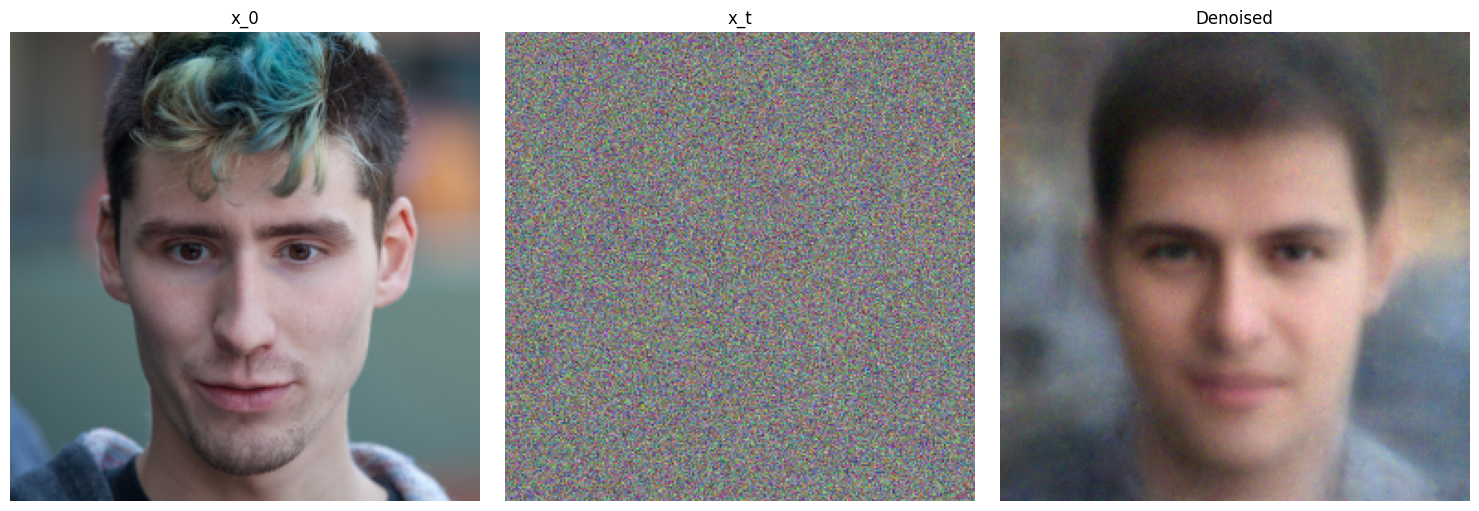

In [13]:
def denoise(x_t, t, eps):
    """
    Perform single-step denoising using the predicted noise.
    i.e. x_0_hat from the DPS paper

    Args:
        x_t: Noisy image at timestep t
        t: Current timestep
        eps: Predicted noise from the model

    Returns:
        Denoised image prediction using the diffusion model equation
    """

    score = - eps / np.sqrt(1.0 - alphas_cumprod[t])

    ############### begin: complete the following code section  ###############
    x_0_hat = 1 / np.sqrt(alphas_cumprod[t]) * (x_t + (1 - alphas_cumprod[t]) * score)
    return x_0_hat

    ############### end: complete the following code section  ###############


# Load and preprocess sample image
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
img = Image.open('data/samples/00015.png').convert('RGB') # Replace with your choice of test image
img = transform(img)
ref_img = img.to(device).unsqueeze(dim=0) # (B, C, H, W)

# Denoise
t = 700 # Choose timestep
t = torch.tensor([t], device=device)  # Wrap in list to make it 1D tensor
noisy_img = forward_process(ref_img, t)
model_output = model(noisy_img, t)
model_output, model_var_values = torch.split(model_output, noisy_img.shape[1], dim=1)

denoised_img = denoise(noisy_img, t, model_output)

images = [clear_color(ref_img), clear_color(noisy_img), clear_color(denoised_img)]
titles = ["x_0", "x_t", "Denoised"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
      ax.imshow(images[i])
      ax.set_title(titles[i])
      ax.axis('off')

plt.tight_layout()
plt.show()

## Evaluate the result

This section calculates standard image quality metrics to evaluate denoising performance:
1. PSNR (Peak Signal-to-Noise Ratio): Measures noise level/reconstruction quality (higher the better)
  *   *your result should be approx. 32 at t=100*

2. LPIPS (Learned Perceptual Image Patch Similarity): Measures perceptual similarity (lower the better)
  *   *your result should be approx. 0.1 at t=100*

In [14]:
import lpips
ref_img_np = ref_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
sample_np = denoised_img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Calculate PSNR & LPIPS
psnr_value = psnr(ref_img_np, sample_np, data_range=ref_img_np.max() - ref_img_np.min())
loss_fn = lpips.LPIPS(net='alex').to(device)
lpips_value = loss_fn.forward(ref_img, denoised_img)

print("PSNR:", psnr_value)
print("LPIPS:", lpips_value.item())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
PSNR: 18.870882008614775
LPIPS: 0.523982584476471
